# YoloV2 - detection de chiffres avec le MNIST

Ce notebook contient une simple boucle d'entrainement pour un modèle de detection. Toutes les implementation - architecture, fonction d'activation et loss - sont présente dans le package `yolo`. 

Pour une version "TP", voir `yolo_tp.ipynb`.

## Génération des datasets

In [3]:
import os

PATH_DATASETS = "datasets/"
PATH_MNIST = os.path.join(PATH_DATASETS, "source")
PATH_TRAIN_SET = os.path.join(PATH_DATASETS, "train_set")
PATH_VAL_SET = os.path.join(PATH_DATASETS, "validation_set")

if not os.path.exists(PATH_DATASETS):
    os.mkdir(PATH_DATASETS)

In [23]:
from utils.generate_dataset import generate_dataset
from torchvision.datasets.mnist import MNIST

print("Generating train set...")
generate_dataset(
    source_dataset=MNIST(PATH_MNIST, train=True, download=True),
    path_dataset=PATH_TRAIN_SET,
    sample_count=5000,
    image_width=512,
    image_height=512,
    min_objects_per_image=0,
    max_objects_per_image=20,
    noise_strength=0
)

print("Generating test set...")
generate_dataset(
    source_dataset=MNIST(PATH_MNIST, train=False, download=True),
    path_dataset=PATH_VAL_SET,
    sample_count=500,
    image_width=512,
    image_height=512,
    min_objects_per_image=0,
    max_objects_per_image=20,
    noise_strength=0
)

print("Done!")

Generating train set...


100%|██████████| 5000/5000 [01:09<00:00, 72.16it/s]


Generating test set...


100%|██████████| 500/500 [00:07<00:00, 71.11it/s]

Done!


### Visualisation des datasets

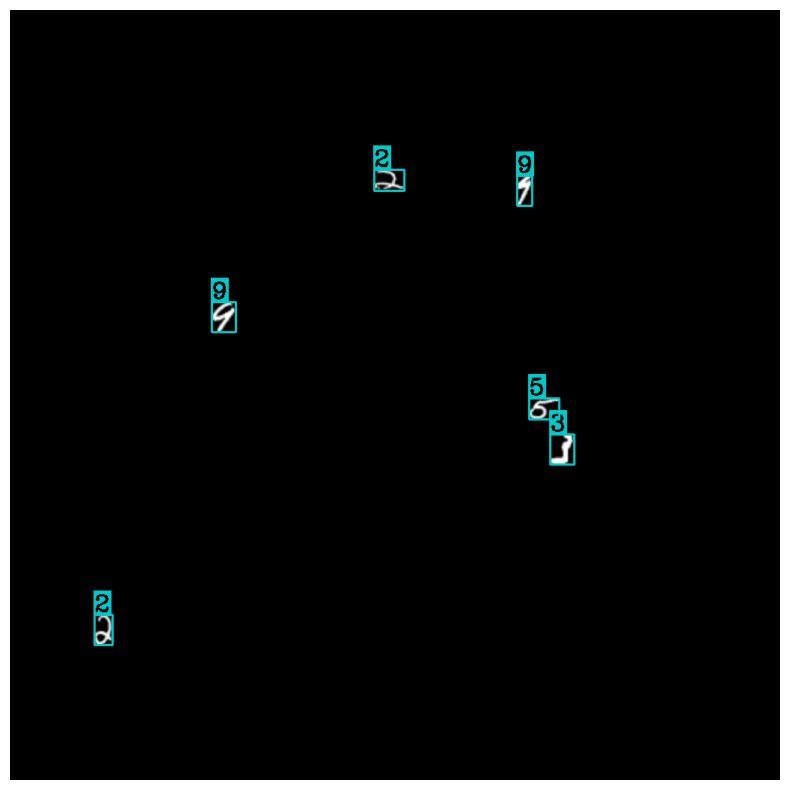

In [24]:
from utils.display_boxes import display_random_dataset_samples

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

images = display_random_dataset_samples(
    path_dataset=PATH_TRAIN_SET,
    sample_count=1
)

for image in images:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

## Entraînement

In [25]:
from torchvision.models.mobilenetv2 import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch
import torchvision.transforms as transforms

from yolo.model import YoloDetector
from yolo.dataset import YoloDataset, collate_fn
from yolo.metrics import CocoEvaluator
from yolo.post_processor import non_maximum_suppression, filter_by_score


if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

### Chargement des datasets et calcul des priors

In [26]:
path_train_annotations = os.path.join(PATH_TRAIN_SET, "annotations.json")
path_train_images = os.path.join(PATH_TRAIN_SET, "images")

path_val_annotations = os.path.join(PATH_VAL_SET, "annotations.json")
path_val_images = os.path.join(PATH_VAL_SET, "images")

train_dataset = YoloDataset(path_train_annotations, path_train_images)
val_dataset = YoloDataset(path_val_annotations, path_val_images)

priors = train_dataset.get_priors(cluster_count=3)

print("Priors utilisés:")
print(priors)

Priors utilisés:
[[12.94792396 19.99994168]
 [ 6.51933702 20.        ]
 [18.3101176  19.56420654]]


### Boucle de train et validation

Note: un modèle de type `YoloDetector` change de comportement entre le train et le test:
- Pendant le train, appeler le modèle en passant les GT retourne directement la loss.
- Pendant le test, le modèle retourne les boîtes décodées.

Les détections sont représentées sour la forme d'un dictionnaire
- `"boxes"`: les bounding boxes dans le format _xywh_
- `"scores"`: un vecteur des scores de chaque boîte
- `"labels"`: un vecteur des labels de chaque boîte

In [ ]:
def train_step(
    detector: YoloDetector,
    data_loader: DataLoader,
    optimizer: optim.Optimizer,
    image_transforms: torch.nn.Module,
    device: torch.device
) -> float:
    """Run a single train epoch.

    Args:
        detector (YoloDetector): Yolo model.
        data_loader (DataLoader): Torch data loader.
        optimizer (Optimizer): Torch optimizer.
        image_transforms (nn.Module): Transforms applied to the image.
        device (torch.device): Model device.

    Returns:
        float: Average loss over the epoch.
    """
    detector.train()
    running_loss = 0

    for images, targets in tqdm(data_loader):
        optimizer.zero_grad()

        images = images.to(device)
        images = image_transforms(images)

        loss = detector(images, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(data_loader)


def validation_step(
    detector: YoloDetector,
    data_loader: DataLoader,
    image_transforms: torch.nn.Module,
    device: torch.device,
    scheduler: optim.lr_scheduler.LRScheduler | None = None
) -> float:
    """Run a single validation step.

    Args:
        detector (YoloDetector): Yolo model.
        data_loader (DataLoader): Torch data loader.
        image_transforms (nn.Module): Transforms applied to the image.
        device (torch.device): Model device.
        scheduler (LRScheduler, optional): Learning scheduler

    Returns:
        float: mAP over the validation set.
    """
    detector.eval()

    # L'objet ci-dessous est un wrapper autour de la lib `pycocotools`. pycocotools est
    # une library qui n'est pas très pratique à utiliser, mais implemente les fonctions
    # pour le calcul de la mAP, ce wrapper permet d'eviter tout le boilerplate
    # necessaire.
    evaluator = CocoEvaluator()

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            images = image_transforms(images)

            detections = detector(images)

            for detection, target in zip(detections, targets):
                evaluator.add_detections(detection, target)

    metrics = evaluator.compute_metrics()

    if scheduler is not None:
        scheduler.step(metrics)

    return metrics



### Création du modèle

On utilise le feature extractor de MobileNetV2, il a l'avantage d'être plutot léger. Sa feature map contient 1280 caractéristiques.

In [28]:
detector = YoloDetector(
    backbone=mobilenet_v2(
        weights=MobileNet_V2_Weights.DEFAULT,
        progress=True
    ).features,
    priors=priors,
    num_classes=10,
    feature_map_depth=1280  # Profondeur de la feature map du MobileNet
).to(DEVICE)

detector

YoloDetector(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps

### Parametrage de l'entrainement

On utilise Adam comme optimizer, avec un scheduler pour réduire le learning rate lorsque la mAP n'augmente plus.

In [29]:
batch_size = 12  # A choisir en fonction de la GPU
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
optimizer = optim.Adam(detector.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max")

# Valeurs de normalisation utilisées par le MobileNet.
image_transforms = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

best_checkpoint = None
best_map = 0

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    loss = train_step(detector, train_loader, optimizer, image_transforms, DEVICE)
    metrics = validation_step(detector, val_loader, image_transforms, DEVICE, scheduler)

    print(f"Train loss over the epoch: {loss:.2f}")
    print(f"Validation mAP: {metrics:.2f}")

    if metrics > best_map:
        best_map = metrics
        best_checkpoint = detector.state_dict()

print("Training done!")

Epoch 1/5


  0%|          | 0/42 [00:00<?, ?it/s]


TypeError: to() received an invalid combination of arguments - got (Normalize), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


In [37]:
torch.save(best_checkpoint, "checkpoint.pth")

### Visualisation des resultats

In [9]:
detector.load_state_dict(torch.load("checkpoint.pth"))
detector.eval()

YoloDetector(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps

In [10]:
from utils.display_boxes import display_image_with_boxes
import random
import cv2

path_image = os.path.join(path_val_images, random.choice(os.listdir(path_val_images)))


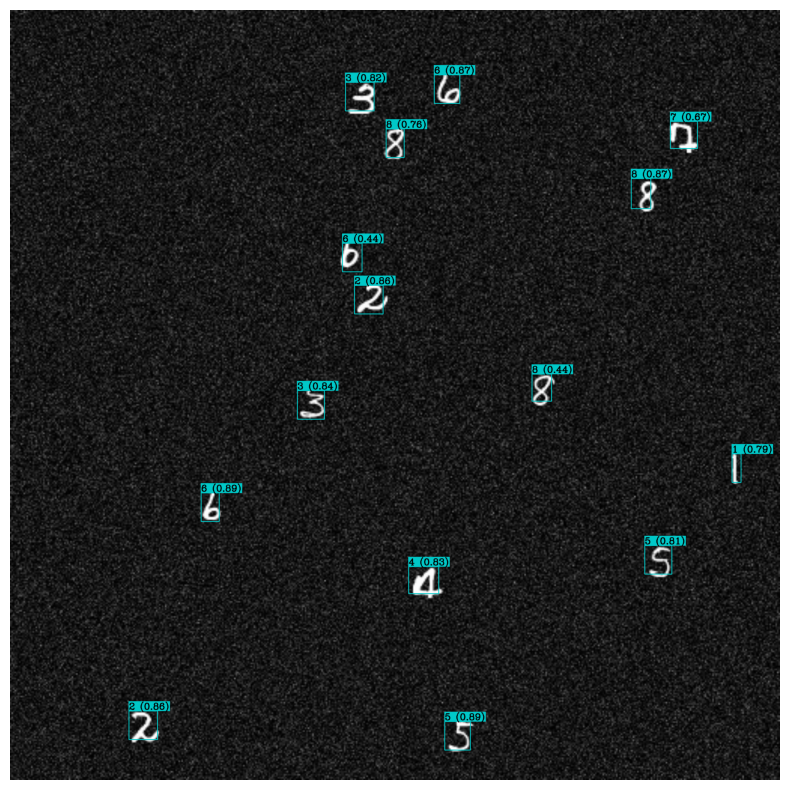

In [15]:
image = cv2.imread(path_image)
image_torch = torch.from_numpy(image).to(torch.float32)
image_torch = torch.moveaxis(image_torch, -1, 0) / 255
image_torch = image_torch.unsqueeze(0)
image_torch = image_transforms(image_torch)
image_torch = image_torch.to(DEVICE)

with torch.no_grad():
    detector.eval()
    detections = detector(image_torch)[0]

detections = filter_by_score(detections, 0.3)
detections = non_maximum_suppression(detections)

image_with_detections = display_image_with_boxes(
    image,
    boxes=detections["boxes"],
    labels=detections["labels"],
    scores=detections["scores"],
    mode="xywh",
    display_labels=True,
    scaling_factor=5
)

plt.imshow(image_with_detections)
plt.axis("off")
plt.show()

In [12]:
#

In [17]:
print(path_image)

datasets/validation_set/images/00354.png


# OCR (un peu nul)

torch.Size([64, 128, 3])
torch.Size([3, 64, 128])
[2 2 4 4]
[2 2 4 4]


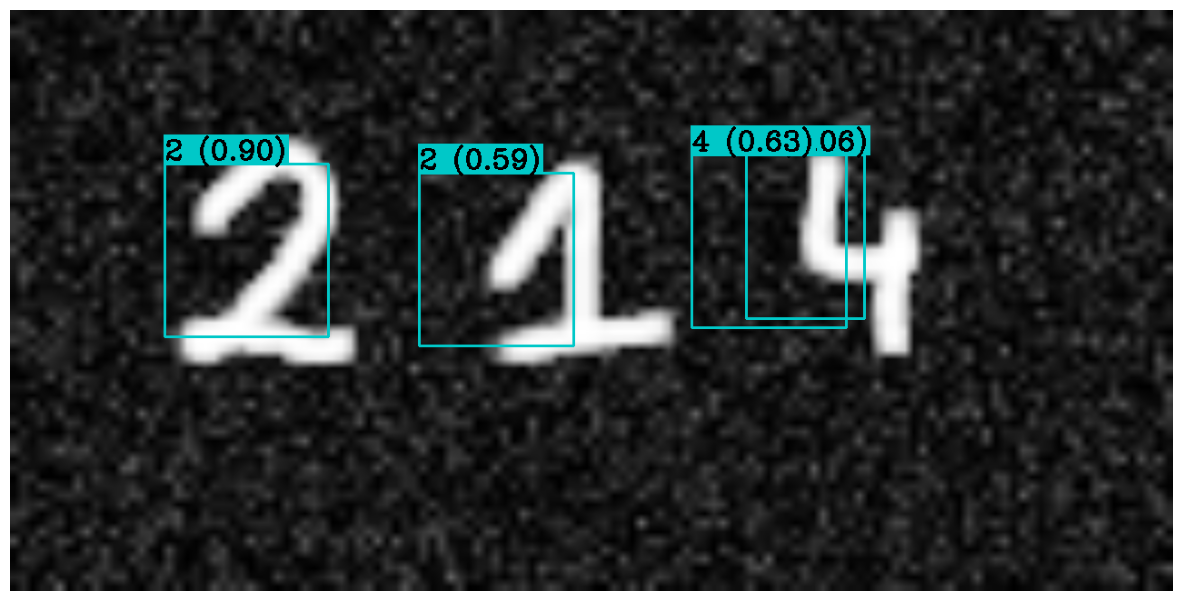

In [22]:
path_image = "test.png"

image = cv2.imread(path_image)
image_torch = torch.from_numpy(image).to(torch.float32)
print(image_torch.shape)
image_torch = torch.moveaxis(image_torch, -1, 0) / 255
print(image_torch.shape)
image_torch = image_torch.unsqueeze(0)
image_torch = image_transforms(image_torch)
image_torch = image_torch.to(DEVICE)


with torch.no_grad():
    detections = detector(image_torch)[0]

print(detections["labels"])

# detections = filter_by_score(detections, 0.3)
# detections = non_maximum_suppression(detections)

print(detections["labels"])

image_with_detections = display_image_with_boxes(
    image,
    boxes=detections["boxes"],
    labels=detections["labels"],
    scores=detections["scores"],
    mode="xywh",
    display_labels=True,
    scaling_factor=10
)

plt.imshow(image_with_detections)
plt.axis("off")
plt.show()